

## A/B TESTS RESULTS 

### Overview

The company has the results of A/B test under which the users recieved different sets of promotional offers.
We know that APRU in Test Group is 5% higher than in Control Group.
In Control Group 1928 out of 202103 users are paying, in the Test Group there are 1805 paying users out of 202667.

What set of promotional offers is better? What metrcis should be taken into consideration to take a decision?



## Data Loading, Preparation and Initial Exploration

In [36]:
# import required liabraries

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
from scipy import stats
import numpy as np
from tqdm.auto import tqdm

In [3]:
# The data is stored on Yandex disc, we use Yandex API:

base_url = base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

# get loading link


final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']


# read the file
df = pd.read_csv(download_url, sep=';')

In [4]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [5]:
# check the size of the dataset
df.shape

(404770, 3)

In [6]:
# check types
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [7]:
# check NAs
df.isna().sum()

# there are no NA cells

user_id      0
revenue      0
testgroup    0
dtype: int64

In [8]:
# check duplicates
df['user_id'].nunique()
# the number of unique users is equal to number of rows, which means there are no duplicates in ID numbers

404770

In [9]:
# explore statistics in each group
df.groupby('testgroup').describe()['revenue']

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


In [10]:
# divide users into subgroups (control and test in general, and paying users in both control and test groups) 
users_a = df.query('testgroup=="a"')
users_b = df.query('testgroup=="b"')
paying_a = users_a.query('revenue>0')
paying_b = users_b.query('revenue>0')

Text(0.5, 1.0, 'Group A')

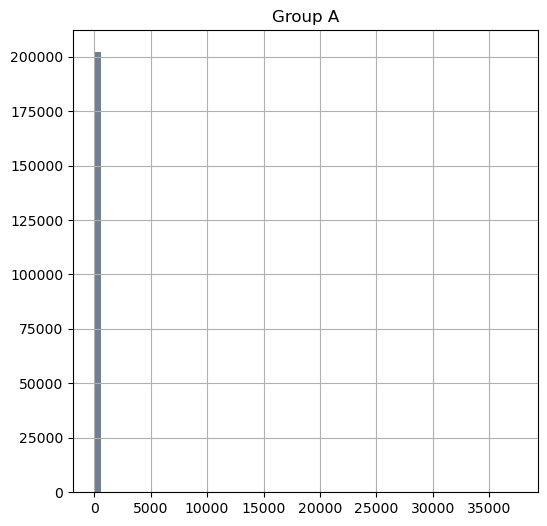

In [11]:
# visualisiton of revenue in the groups

plt.figure(figsize=[6, 6])
users_a.revenue.hist(bins=60, color='slategrey')
plt.title("Group A")



Text(0.5, 1.0, 'Group B')

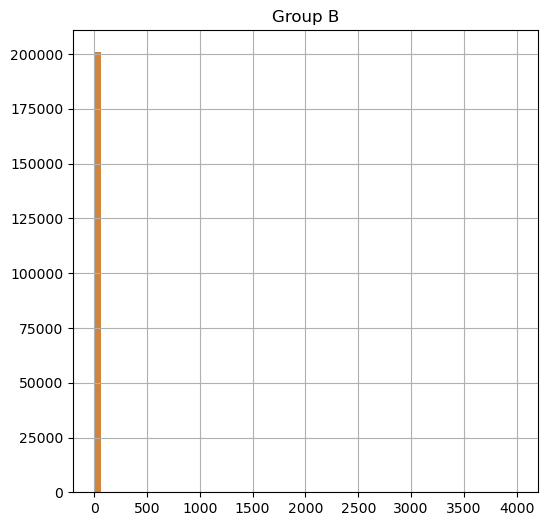

In [12]:
plt.figure(figsize=[6, 6])
users_b.revenue.hist(bins=60, color='peru')
plt.title("Group B")

Based on the initial exploration and visualization  we can see that:
 - major part of users did not bring any revenue
 - there is a huge difference in the maximum amount of cheque per user (37433 for Group A and 4000 for Gorup B)

## METRICS

### Conversion into payer

In [13]:
# number of users in each group

user_count = df.groupby('testgroup', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'total_no'})
user_count

,testgroup,total_no
0,a,202103
1,b,202667


In [14]:
# create nominative variable which will reflect whether user is paying or non-paying
df['user_type'] = df['revenue'].apply(lambda x: 'paying' if x > 0 else 'non-paying')
df.head()

,user_id,revenue,testgroup,user_type
0,1,0,b,non-paying
1,2,0,a,non-paying
2,3,0,a,non-paying
3,4,0,b,non-paying
4,5,0,b,non-paying


In [15]:
# apply crosstab function to find the distribution of users by the group and by the paying factor 
# (paying or non-paying)

df_crosstab = pd.crosstab(df['testgroup'], df['user_type'])
df_crosstab


user_type,non-paying,paying
testgroup,,
a,200175,1928
b,200862,1805


In [16]:
# merge tables with total numbers of users and distribution of users by type
df_conversion = df_crosstab.merge(user_count, on='testgroup')
df_conversion

,testgroup,non-paying,paying,total_no
0,a,200175,1928,202103
1,b,200862,1805,202667


In [17]:
df_conversion['CR'] = round(df_conversion['paying'] / df_conversion['total_no'] * 100, 3)
df_conversion

,testgroup,non-paying,paying,total_no,CR
0,a,200175,1928,202103,0.954
1,b,200862,1805,202667,0.891


In [18]:
# calculate difference in Converison Rate in p.p. and %
pd.DataFrame({
    'p.p.': [(round(df_conversion.CR[1] - df_conversion.CR[0], 2))],
    '%': [round((df_conversion.CR[1] * 100 / df_conversion.CR[0]) - 100, 2)]
})

,p.p.,%
0,-0.06,-6.6


Based on the above calculations we can see that the conversion in Group B decreased by 0.06 p.p. or 6.6%

### ARPU

In [19]:
# calculate ARPU for both the group, determine the difference
arpu_a = round(users_a.revenue.sum() / users_a.revenue.count(), 2)
arpu_b = round(users_b.revenue.sum() / users_b.revenue.count(), 2)
arpu_diff = round((arpu_b - arpu_a) / arpu_b * 100, 0)
print(f'ARPU for Group A: {arpu_a}')
print(f'ARPU for Group B: {arpu_b}')
print(f'Difference: {arpu_diff}%')

ARPU for Group A: 25.41
ARPU for Group B: 26.75
Difference: 5.0%


From the above calculation we see that ARPU in Group B is 5% higher than in Group A, we can conclude (based on the information provided) that Group B is Test Group and Group A is Control Group.

### REVENUES

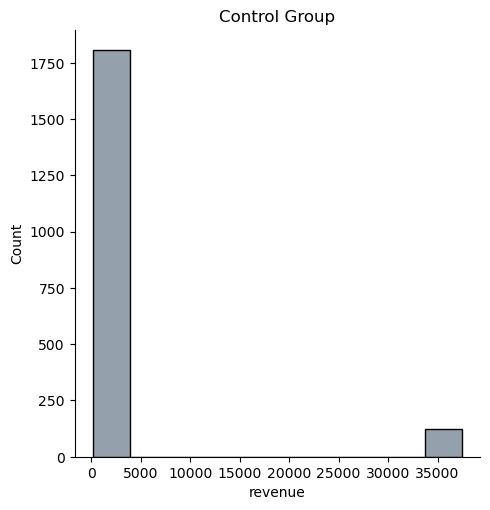

In [20]:
# visualize revenue for Group A
sns.displot(paying_a.revenue, bins=10, color='slategrey')
plt.title("Control Group")
plt.show()

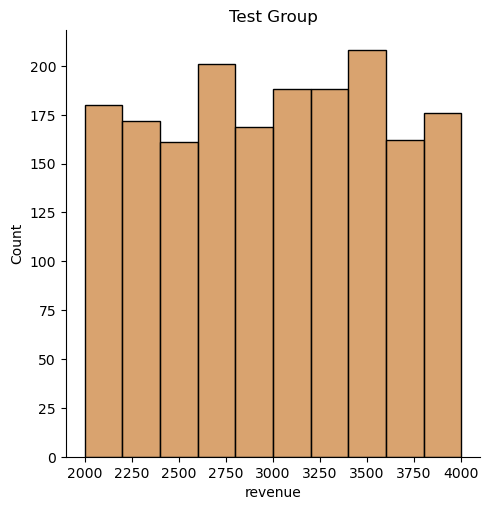

In [21]:
# visualize revenue for Group B
sns.displot(paying_b.revenue, bins=10, color='peru')
plt.title("Test Group")
plt.show()

The first thing which is obvious from the visualization is that there are outliers in the Control Group.
To make further tests more correct, we can divide thw Control Group into 2 sub-groups: the whole groups and the group without outliers

In [22]:
# keep only paying users from the main dataframe
df_ab_paying = df.query('revenue != 0').reset_index().drop(columns=['index', 'user_type'])
df_ab_paying.head()

,user_id,revenue,testgroup
0,73,351,a
1,161,3797,b
2,342,290,a
3,378,3768,b
4,386,250,a


([<matplotlib.axis.XTick at 0x16018c5d0>,
 [Text(0, 0, 'Control'), Text(1, 0, 'Test')])

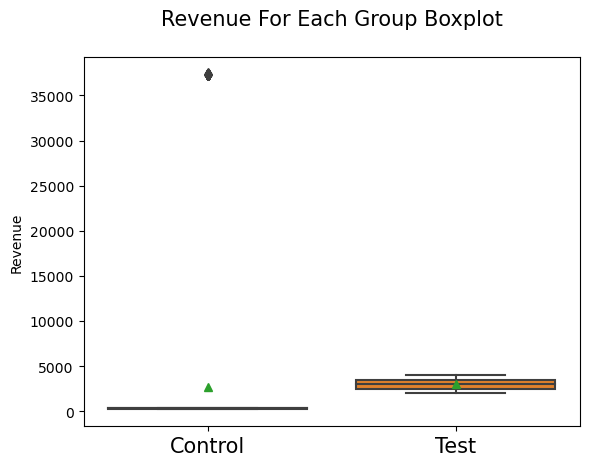

In [23]:
# boxplot для дохода по контрольной (А) и тестовой группу (В)

group_names = ['Control', 'Test']

sns.boxplot(x='testgroup', y='revenue', data=df_ab_paying, showmeans=True)
plt.title('Revenue For Each Group Boxplot\n', fontsize=15)
plt.xlabel('')
plt.ylabel('Revenue')
plt.xticks([0, 1], group_names, fontsize=15)

In [24]:
# try to find the maximum value before the outliers in order to divide the group 

df_ab_paying.query('testgroup == "a"').revenue.quantile([0.75, 0.9, 0.95, 0.93, 0.94])

# before the outliers the maximum value is 399

0.75      361.00
0.90      393.30
0.95    37299.65
0.93      399.00
0.94    37295.00
Name: revenue, dtype: float64

In [25]:
# sub-group from Group A with the revenue more than 400 > 400 
df_ab_paying.query('revenue > 400 and testgroup == "a"').sort_values('revenue').head()

,user_id,revenue,testgroup
183,19496,37293,a
740,81478,37294,a
2161,235859,37294,a
2334,254114,37294,a
315,34535,37294,a


In [26]:
# delete the customers with the highest revenues of Group A from the dataframe with paying customers
ab_paying_without_outliers = df_ab_paying.query('~(revenue > 400 and testgroup == "a")')
ab_paying_without_outliers

,user_id,revenue,testgroup
0,73,351,a
1,161,3797,b
2,342,290,a
3,378,3768,b
4,386,250,a
...,...,...,...
3728,404316,262,a
3729,404526,3120,b
3730,404544,369,a
3731,404603,251,a


In [27]:
# now we will have three groups of paying customers: Group A Full, Group A (wuthout outliers) and Group B

paying_a_no_outliers = ab_paying_without_outliers.query('testgroup == "a"') \
                                          .reset_index() \
                                          .drop(columns='index')

paying_a_full = paying_a

paying_b_full = paying_b

([<matplotlib.axis.XTick at 0x16005efd0>,
 [Text(0, 0, 'Control'), Text(1, 0, 'Test')])

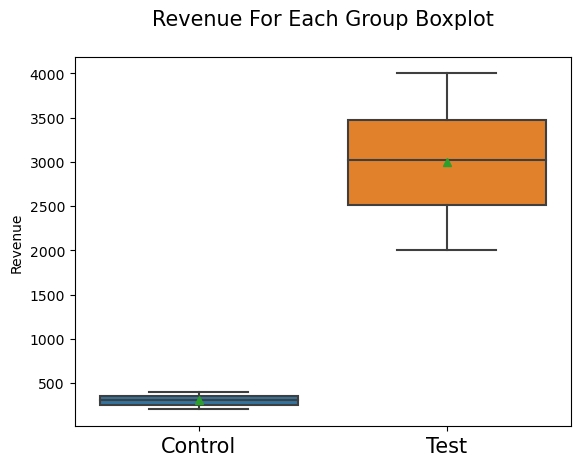

In [28]:
# boxplot для дохода по контрольной группе без выбросов (А) и по тестовой группы (В)

sns.boxplot(x='testgroup', y='revenue', data=ab_paying_without_outliers, showmeans=True)
plt.title('Revenue For Each Group Boxplot\n', fontsize=15)
plt.xlabel('')
plt.ylabel('Revenue')
plt.xticks([0, 1], group_names, fontsize=15)

Удалив выбросы из контрольной группы видно, что среднее значение тестовой группы не входит 3*IQR контрольной группы, что предварительно может указывать на статистически значимые различия.
Теперь визуально оценим распределения дохода для каждой группы.

Visualization of Revenue

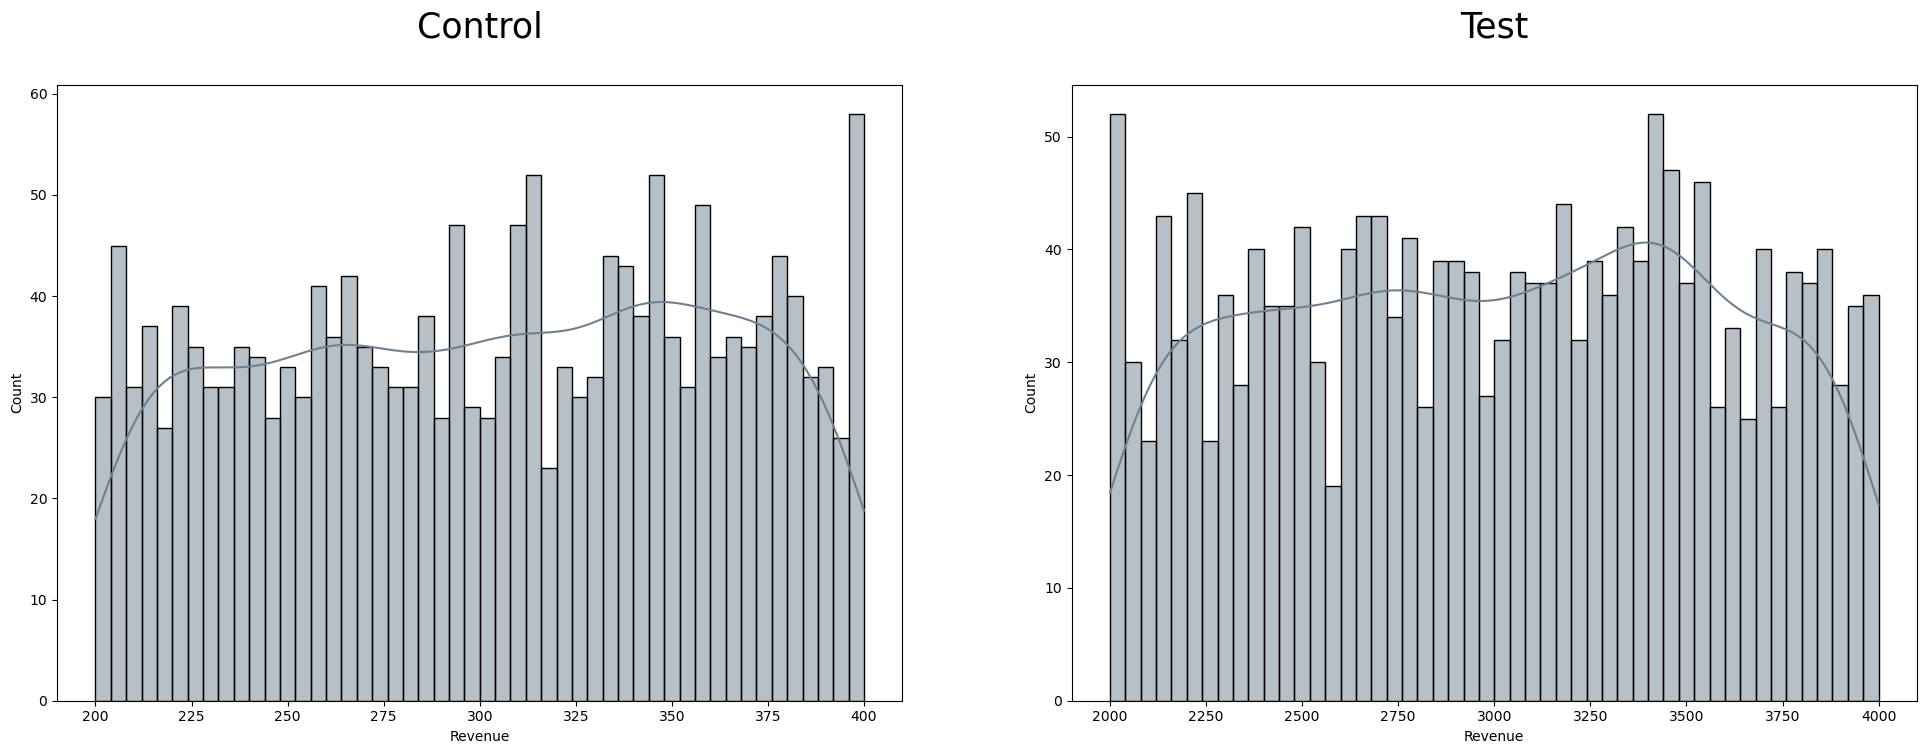

In [35]:
# visualize the revenue for 2 groups: Group A (without outliers) and Group B. Will not plot the graph
# for the full Group A as the outliers will distort the picture

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))  

groups =  [paying_a_no_outliers, paying_b_full]

for ax, title, group in zip(axes, group_names, groups):
    sns.histplot(
        data=group.revenue,
        kde=True,
        bins=50,
        ax=ax,
        color='slategrey')
    ax.set(title=f'{title}\n')
    ax.set_xlabel('Revenue')
    ax.title.set_fontsize(25)

In both the groups the distributions are quite symmetric and do not have strong outliers, which can be a good base for t-Test

### ARPPU

In [30]:
# calculate ARPPU for all groups, which coincides with mean value
ARPPU = pd.DataFrame({
    'control_group_no_outliers': [paying_a_no_outliers.revenue.mean()],
    'control_group_full': [paying_a_full.revenue.mean()],
    'test_group': [paying_b_full.revenue.mean()]},
    index=['ARPPU'])

ARPPU.round(2)

,control_group_no_outliers,control_group_full,test_group
ARPPU,302.46,2664.0,3003.66


In [31]:
arppu_diff_b_a_no_outliers = round(float((ARPPU['test_group'] * 100 / ARPPU['control_group_no_outliers']) - 100), 2)
print(f'Difference between Test Group and  Control Group Without Outliers: {arppu_diff_b_a_no_outliers}%')        

Difference between Test Group and  Control Group Without Outliers: 893.08%


In [32]:
arppu_diff_b_a_full = round(float((ARPPU['test_group'] * 100 / ARPPU['control_group_full']) - 100),2)
print(f'Difference between Test Group and Full Control Group: {arppu_diff_b_a_full}%')

Difference between Test Group and Full Control Group: 12.75%


### EXPLORING OUTLIERS

## EVALUATION OF SIGNIFICANCE

### Significance of Change in the Conversion Rate

In [49]:
# since we have the categorical variable, we use chi-square test on the crosstable 
# that was prepared while calculating the CR
# Null Hypothesis: The CR in the both groups is not significantly different
# Alternative Hypothesis: The cR in the groups is different 

stats.chi2_contingency(df_crosstab)[1].round(3)


0.036

#### Conclusion of Chi-Square Test

We received p-value=0.036 which is less than value of 0.05 (for our purposes assumed to be the border-point).
We can DECLINE the Null Hypothesis on equality of conversion rates in groups A amd B

### Significance of Change in the ARPPU

#### Homoscedasticity

In [62]:
# check homoscedasticity of variane of Control Group (without outliers) and Test Group with Levene's test
# H0: variance of the grups does not statustically differ

stats.levene(paying_a_no_outliers.revenue, paying_b_full.revenue)[1]

LeveneResult(statistic=4256.810323520863, pvalue=0.0)

In [52]:
# check homoscedasticity of variane of Full Control Group  and Test Group
stats.levene(paying_a_full.revenue, paying_b_full.revenue)[1]

3.779689868667878e-19

#### Normality

In [64]:
# check distribution in the Control Group (without outliers) for normlality using Shapiro-Wilka test
# H0: the distribution does not statistically differ from normal one
stats.shapiro(paying_a_no_outliers.revenue)[1]

3.002848260644267e-23

In [57]:
# check distribution in the Control Group (full)
stats.shapiro(paying_a_full.revenue)[1]

0.0

In [58]:
# check distribution in the Test Group 
stats.shapiro(paying_b_full.revenue)[1]

2.4929213770979496e-22

#### T-Tests

In [60]:
# T-Test for Full Control Group and Test Group

stats.ttest_ind(paying_a_full.revenue, paying_b_full.revenue)[1]

0.11153459157259495

In [61]:
# T-Test for  Control Group (without outliers) and Test Group
stats.ttest_ind(paying_a_no_outliers.revenue, paying_b_full.revenue)[1]

0.0

In the first t-test for Full Control Group and Test Group p-value>0.05 which makes it impossible to reject Null Hypothesis on equality of means.

In the t-test for Control Group (without outliers) and Test-Group we received p-value < 0.05. However it seems to be risky to reject Null Hypothesis on equality of means especially keeping in mind the results of Levene's and Shapiro-Wilka tests (where we could not statistically proove the homoscedasticity and normality of distribution).

To be sure that these groups' means statistically differ (and not to worry about homoscedasticity and normality). will use Mann–Whitney U test 

#### Mann–Whitney U test 

In [67]:
# Mann–Whitney U test for Coltrol Group (without outliers) and Test Group
# H0: THe distributions in the groups are identical

stats.mannwhitneyu(paying_a_no_outliers.revenue, paying_b_full.revenue)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [68]:
# Mann–Whitney U test for Full Coltrol Group and Test Group

stats.mannwhitneyu(paying_a_full.revenue, paying_b_full.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

In both the tests(control groups without outliers/test group amd full control group/test group) we received p=value < 0.05 which allows us to reject the Null Hypothesis that the distributions of the groups in the tests are identical. THat supports the assumption that the differences in means/ARPPUs between the control and test groups are statistically significant.

In order to evaluate the borders of the changes, will use bootstrap method on the mean. Will apply bootstrap to check the difference in the Control Group (without outliers) and Test Group.

#### Bootstrap

In [88]:
# function allowing the cehck hypothesis wth the help of bootstrap
def get_bootstrap(
    data_column_1,  # values of the 1st sample
    data_column_2,  # values of the 2nd sample
    boot_it=1000,  # number of bootstrap sub-samples
    statistic=np.mean,  # statistic we are checking
    bootstrap_conf_level=0.95  # significance level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # taking sub-samples
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  
        ).values
        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        boot_data.append(statistic(samples_2 - samples_1))

    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quantile = (1 - bootstrap_conf_level) / 2
    right_quantile = 1 - (1 - bootstrap_conf_level) / 2
    conf_interval = pd_boot_data.quantile([left_quantile, right_quantile])
    
    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Visualization
    plt.hist(pd_boot_data[0], bins=50, color='slategrey')
    plt.style.use('ggplot')
    plt.vlines(conf_interval, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot data by mean")
    plt.show()
    
    return {"boot_data": boot_data,
            "ci": conf_interval,
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

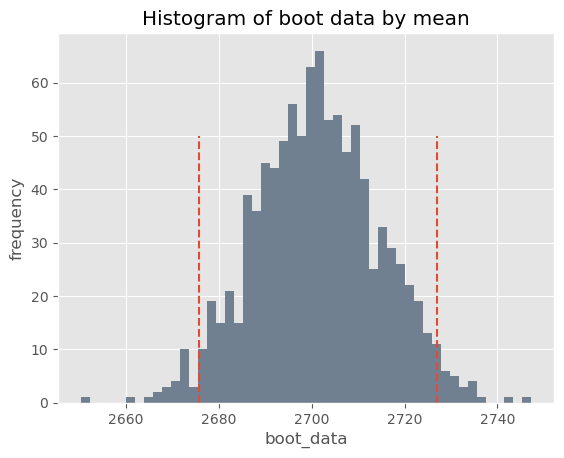

p-value: 0.00


In [90]:
# Using bootstrap compare the means of the Control Group (without outliers) and the Test Group
# H0 : means in the groups do not statistically differ

booted_data_control_test = get_bootstrap(
              paying_a_no_outliers.revenue,
              paying_b_full.revenue)

print(f'p-value: {booted_data_control_test["p_value"]:.2f}')


In [91]:
# 95% confidence interval for difference between the Control Group (without outliers) and the Test Group
booted_data_control_test["ci"]

,0
0.025,2675.744086
0.975,2726.916108


  0%|          | 0/1000 [00:00<?, ?it/s]

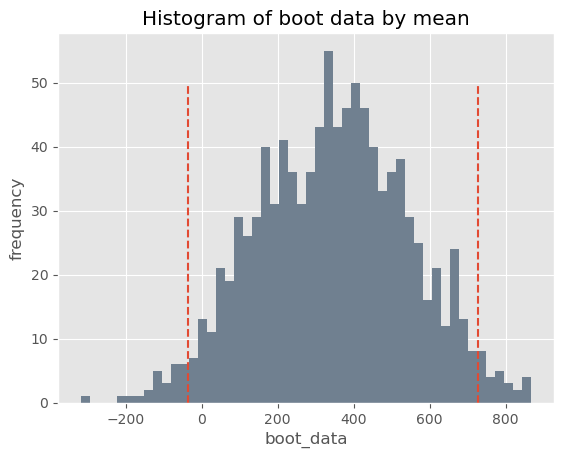

p-value: 0.08


In [94]:
# Will compare the means of the Full Control Group  and the Test Group
booted_data_full_control_test = get_bootstrap(
              paying_a_full.revenue,
              paying_b_full.revenue)

print(f'p-value: {booted_data_full_control_test["p_value"]:.2f}')


In [93]:
# 95% confidence interval for difference between the Full Control Group  and the Test Group
booted_data_full_control_test["ci"]

,0
0.025,-46.444113
0.975,704.179279


Bootstrap for difference in the mean proved the following:

Means of the Control Group (without outliers) and the Test Group statistically differ with the p-value < 0.05. This allows us to reject the Null Hypothesis on the equality of the means. 

Measn of the Full Control Group and the Test Group do no statistically differ, p-value > 0.05. This does not allow to reject the Null Hypothesis. 0 is within the confidence interval though very close to the border. 

## CONSCLUSIONS

1. In the Control Group there is a segment of customers with significanly higher revenues, which explains the outliers in the distribution of revenues in this group. Maximum revenue in this segment is 37433, which is considerably higher than the maximum in the same group but without outliers (400). In the Test Group there is no such a segment. 

2. Conversion in the Test Group is 0.06 p.p. or 6.65% lower than in the Control Group.  The probability of statistical randomness of such decrease is 0.03 which is less than the assumed border (alpha-level) of 0.05. 


3. It is possible that the decrease of the conversion rate in the test group can be explained by the absence of high-revenue customers. Other reasons can also affect the decrease, but to check them we will need more data. 


4. ARPPU is 12.75% higher in the Test Group compared to Full Control Group. While undergoing statistic tests for the Full Control Group and Test Group we could only prove statistically significant difference under Mann–Whitney U test, where p-value was less than 0.05. Bootstrap for the difference in the means and T-Test showed p-value > 0.05. However, it should be noted that T-test was not quite adequate in this situation (absence of normality and homoscedasticity of distributions) and under bootstrap p-value was quite close to the benchmark of 0.05 (even in the conditions of considerable outliers when we compared means), we can rely on the Mann–Whitney U test.


5. When the outliers were excluded, we received increased in ARPPU by 893.08%. Statistical tests in this comparison showed p-value < 0.05. Bootstrap showed that the change is in the range between 2675.74 and 2726.91 with the probability of 95%.


6. Generally speaking the set of offers for the Test Group turned out to be better with high probability. Despite the decrease in the Conversion Rate, ARPU metric increased by 5% in the Test Group.   


7. New set of promotional offers can be used for all the customers. However, before doing this, it is recommended to make further research why the high-revenue segment disappeared from the Test Group and what are the possible actions to retain such customers. This will help to maintain conversion rate on the same level and increase total revenue.  